# <h1><center> **Homework 3- JPEG Compression**  </center></h1>

# **In this notebook, there will be 10 sub-questions marked from (a) to (j). Add the answers to those questions to your submission.**

**## Introduction of principles of the JPEG baseline coding system.**

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Import the necessary libraries:

In [2]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform,io,util,img_as_ubyte
from skimage import restoration
import sys
import cv2
import math
from PIL import Image
from scipy import fftpack

# **(a) Preliminary question: Give one example of an advantage of the JPEG algorithm over another image compression algorithms.**

# 1. Helper Functions - In this section, You can see the implementation of each function

In this section we implement several helper functions which will be used in the implementation of JPEG compression and decompression. 

The functions ***quantize*** and ***dequantize*** are given:



In [3]:
def load_quantization_table(quality,block_size):
    q = np.array([[16, 11, 10, 16, 24, 40, 51, 61],
            [12, 12, 14, 19, 26, 58, 60, 55],
            [14, 13, 16, 24, 40, 57, 69, 56],
            [14, 17, 22, 29, 51, 87, 80, 62],
            [18, 22, 37, 56, 68, 109, 103, 77],
            [24, 35, 55, 64, 81, 104, 113, 92],
            [49, 64, 78, 87, 103, 121, 120, 101],
            [72, 92, 95, 98, 112, 100, 103, 99]])* quality   # JPEG normalizing array and zig-zag reordering
    if (block_size != 8):
        q = transform.resize(q, (block_size, block_size), preserve_range=True)
    return q

def quantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return np.array((block / q).round().astype(np.int32))

def dequantize(block, quality,block_size):
    q = load_quantization_table(quality,block_size)
    return block * q

1. ***zigzag(M,N)***

In [4]:
def zigzag(M,N):
  order = []
  x = 0;  y = 0
  order.append(N*y+x)
  if (y+1 < M):
    y += 1
    order.append(N*y+x)
  up = 1
  x += 1; y -= 1
  while (x >= 0 and x < N and y >= 0 and y < M):
    order.append(N*y+x)
    if (up == 1):   # up and right zigzag
      while (x+1 < N and y-1 >= 0):
         x += 1; y -= 1
         order.append(N*y+x)
      if (x+1 < N):
         x += 1
         order.append(N*y+x)
      else:
         y += 1
         order.append(N*y+x)
      up = 0

    else:  # down and left zigzag 
      while (x-1 >= 0 and y+1 < M):
         x -= 1; y += 1
         order.append(N*y+x)
      if (y+1 < M):
         y += 1
         order.append(N*y+x)
      else:
         x += 1
         order.append(N*y+x)
      up = 1
    if (up == 1):
      x += 1; y -= 1
    else:
      x -= 1; y += 1

  return order


order = zigzag(3,4)
print (order)
order = zigzag(4,4)
print (order)



[0, 4, 1, 2, 5, 8, 9, 6, 3, 7, 10, 11]
[0, 4, 1, 2, 5, 8, 12, 9, 6, 3, 7, 10, 13, 14, 11, 15]


2.   Implementation of ***block_to_zigzag(block, order)***

This function transforms a *block_size* x *block_size* block of your image to a 1D array ordered according to the list of indices given in *order*. 

Hint: Use block.flatten()

3.   Implementation of ***zigzag_to_block(zigzag, order)***

This function performs the inverse operation. Given a 1D array ordered according to the list of indices given in *order*, it transforms it to a **square** block with its elements in their original location.


In [5]:
def block_to_zigzag(block,order):
  zigzag = block.flatten()[order]
  return zigzag

def zigzag_to_block(zigzag,order):
  block_size = int(np.sqrt(zigzag.size))
  block = zigzag.reshape((block_size, block_size))
  return block

4. Implement 2D DCT and IDCT. We use ***fftpack.dct*** and ***fftpack.idct***.

In [6]:
def dct_2d(image):
  image = fftpack.dct(fftpack.dct(image, axis=0, norm='ortho'), axis=1, 
                      norm='ortho')  # applying DCT on both axis
  return image

def idct_2d(image):
  ## Your code here ##
  image = fftpack.idct(fftpack.idct(image, axis=0, norm='ortho'), axis=1, 
                      norm='ortho')  # applying IDCT on both axis
  return image

# 2. JPEG Compression and Decompression

1.   Load and show the image of your choice (grayscale). make sure that you convert it to uint32.



Image shape:(512, 512), Image data type:uint32


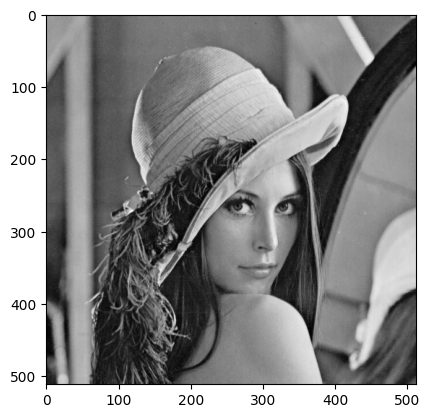

In [7]:
img = io.imread('https://www.eecs.qmul.ac.uk/~phao/IP/Images/Lena.bmp')  # importing picture of Lenna. This image is being used widely in Image Processing!
if len(img.shape) != 2:
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # if not in grayscale
img = np.array(img, dtype=np.uint32)
print('Image shape:{}, Image data type:{}'.format(img.shape,img.dtype))
plt.imshow(img, cmap = 'gray')

# **(b) Write a block diagram that will describe the JPEG compression algorithm for images.**
# **(c) Write a block diagram that will describe the process of the restoration of an image that was compressed by the JPEG algorithm.**
**hint: you can use the following code and its comments**

In [8]:
# im2jpeg Compresses an image using a JPEG approximation.
# im2jpeg(img,block_size, quality) compresses image based on block_size x block_size DCT transforms and coefficient quantization.
# Input quality determines the amount of information that is lost and compression achieved. 

def im2jpeg(img, block_size=8, quality=1):
    if not isinstance(img, np.ndarray) or img.dtype != np.uint32: 
        print("The input must be a UINT32 image.")
        return
    rows, cols = img.shape[0], img.shape[1]
    # block size: (block_size x block_size)
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of {}".format(block_size)))

    # End-Of-Block (EOB) symbol
    eob = 256
    jpeg_list = list()
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # loop over image blocks
    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):
                # Code the following steps
                # 1. extract a block of size block_size x block_size and center the data range on zero: [0, 255] --> [-128, 127]:
                
                im_block = img[i: i + block_size, j : j + block_size]
                block = im_block.astype(np.int32) - 128

                # 2. perform dct to the block:
                
                block_dct = dct_2d(block)

                # 3. quantize your dct block using given quality factor:
                
                qblock_dct = quantize(block_dct, quality, block_size)

                # 4. reorder in a zigzag pattern
                
                zigzag_qblock__dct = block_to_zigzag(qblock_dct, order)

                # 5. omit trailing zeros in reordered block
                
                if zigzag_qblock__dct[0] != 0:
                  last_nonzero = np.max(np.nonzero(zigzag_qblock__dct))
                  zigzag_qblock__dct_without_zeros = np.zeros(last_nonzero + 2)
                  zigzag_qblock__dct_without_zeros[0 : last_nonzero + 1] = zigzag_qblock__dct[0 : last_nonzero + 1]
                
                # 6. add eob in the end of the block
                
                  zigzag_qblock__dct_without_zeros[last_nonzero + 1] = eob
                else:
                  zigzag_qblock__dct_without_zeros = np.array([eob])
                
                # 7. append the dct block to the list
                jpeg_list.append(zigzag_qblock__dct_without_zeros)
                
    #convert the list to array
    jpeg_array = np.concatenate(jpeg_list,axis=None)
    return jpeg_array



# jpeg2im Decodes an IM2JPEG compressed image.
# jpeg2im(jpeg_img,block_size,quality) decodes compressed image jpeg_img, generating reconstructed approximation X. 
# jpeg_img is generated by im2jpeg.

def jpeg2im(jpeg_img, block_size=8, quality = 1):
    eob = 256
    
    # find the zigzag order
    order = zigzag(block_size, block_size)

    # find the End-Of-Block (EOB) symbols
    ends_of_blocks = np.where(jpeg_img == eob)[0]
    num_of_block = ends_of_blocks.shape[0]
    
    # assuming that the image height and width are equal
    image_side = int(math.sqrt(num_of_block)) * block_size
    blocks_per_line = image_side // block_size
    
    # create new empty image:
    npmat = np.empty((image_side, image_side), dtype=np.int32)
    
    start = 0
    for block_index, end in enumerate(ends_of_blocks):
        # 1. initialize new block
        zz_list = np.zeros(block_size*block_size)

        # 2. assign values from jpeg_img into beginning of zz_list
        zz_list[:end-start] = jpeg_img[start:end]

        # 3. convert zz_list back into block
        quant_matrix = zigzag_to_block(zz_list, order)

        # 4. dequnatize
        dct_matrix = dequantize(quant_matrix,quality,block_size)

        # 5. perform idct to block
        block = idct_2d(dct_matrix)

        # find the place in the image to put the block
        i = (block_index // blocks_per_line * block_size) 
        j = (block_index % blocks_per_line * block_size)
        npmat[i:i+block_size, j:j+block_size] = block + 128
        start = end + 1
    
    return npmat
    

3. Compress your image using the JPEG compression algorithm calling ***im2jpeg*** and restore the image from its compressed form calling ***jpeg2im***.   
    * Present the original and restored images.
    * Print the number of elements in the original and compressed images. 
    * Explain why blocking effects can be seen in the restored image.   
    * Show the blocking effects by zooming in for intresting parts of the image. 

There are 1048576 elements in the original image
There are 403440 elements in the compressed image
Compression rate : 0.3847503662109375


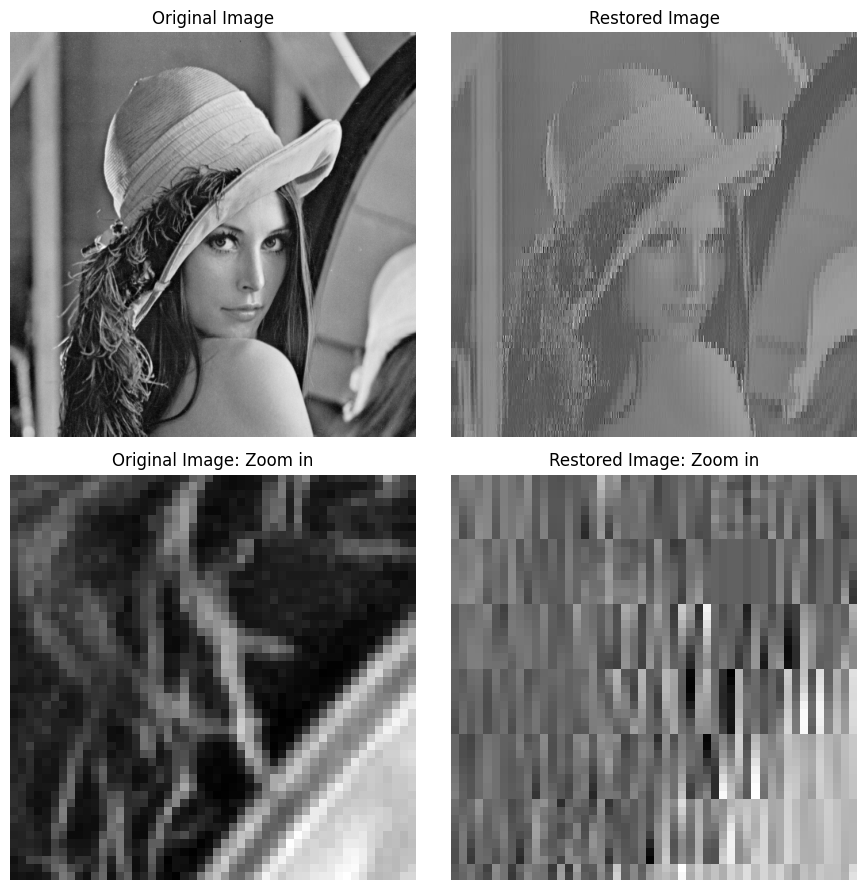

In [9]:
compressed = im2jpeg(img)
restored = jpeg2im(compressed)

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 9))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image'), ax[0].axis('off')
ax[1].imshow(restored, cmap='gray')
ax[1].set_title('Restored Image'), ax[1].axis('off')
ax[2].imshow(img[200:250,200:250], cmap='gray')
ax[2].set_title("Original Image: Zoom in"), ax[2].axis('off')
ax[3].imshow(restored[200:250,200:250], cmap='gray')
ax[3].set_title("Restored Image: Zoom in"), ax[3].axis('off')
plt.tight_layout()

print(f'There are {str(img.nbytes)} elements in the original image')
print(f'There are {str(compressed.nbytes)} elements in the compressed image')
print (f'Compression rate : {float(compressed.nbytes/img.nbytes)}')

# **(d) Is the restoration quality good enough? Can you see Lenna? What details are missing in the restored image? Note that there is a compression rate of 0.384 between the compressed and the original image!**
# **(e) Take a look at the zoom-in (on Lenna's hair) image and its restored image. Can you recognize Lenna's hair in the restored image? How can you explain it?**

# 3. Analysis

1. Plot the graph of compression ratio (Y axis) versus a “quality” parameter of *im2jpeg* (X axis). Use the supplied function *imratio*.  

Use the following quality parameters: 1,2,4,6,8,10,12,16,20,25

__Remark:__ the “quality” parameter defines the quality of compression and not the quality of restoration. It is defined to be greater or equal to 1. The “quality” equal to 1 corresponds to the best quality of restoration and the worst quality of compression.


In [10]:
def imratio(original_img1,compressed_img2):
    return float(compressed_img2.nbytes)/original_img1.nbytes

Text(0.5, 1.0, 'Compression ratio versus quality')

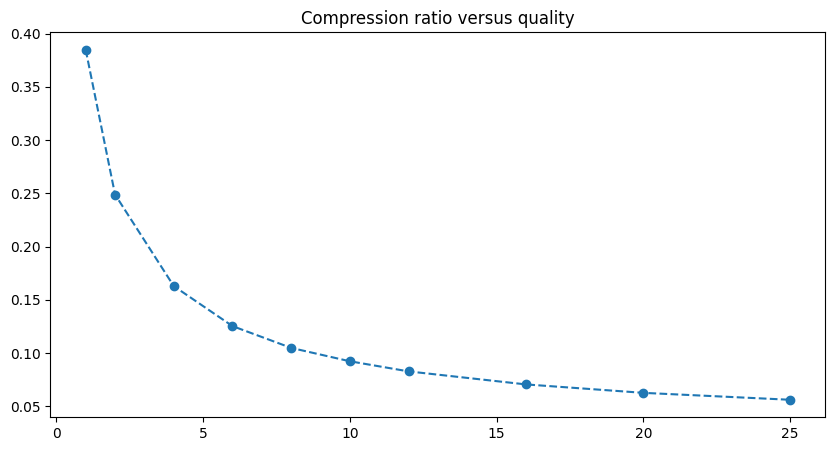

In [11]:
qualities = [1,2,4,6,8,10,12,16,20,25]
ratios = []
for q in qualities:
  jpeg = im2jpeg(img, quality = q)
  ratio = imratio(img, jpeg)
  ratios.append(ratio)

plt.figure(figsize=(10,5))
plt.subplot(111)
plt.plot(qualities, ratios, linestyle='--', marker='o')
plt.title('Compression ratio versus quality')


# **(f) What can you say about the relation between the quality of the compression and the quality of restoration?**
# **(g) What can you say about the relation between the compression ratio and the quality of the compression? What are the considerations need to be taken into account when choosing a quality factor?**

2. The Root Mean Square (RMS) **error of restoration** is defined in the following way:  
\begin{equation*}
RMS = \left( \frac{1}{MN}  \sum_{k=0}^{M-1} \sum_{k=0}^{N-1} (\hat{f}(i,j)-f(i,j))^2 \right)^{0.5}
\end{equation*}

    where $f(i, j)$ is the original image, $\hat{f}(i,j)$ is the restored image and $M \times N$ is the size of both images.    
    
    Plot the graph of Root Mean Square (RMS) Error of restoration (Y axis) versus compression ratio (X axis). This graph is called **Rate-Distortion curve**.  
  



Text(0.5, 1.0, ' RMS error of restoration verus Compression ratio')

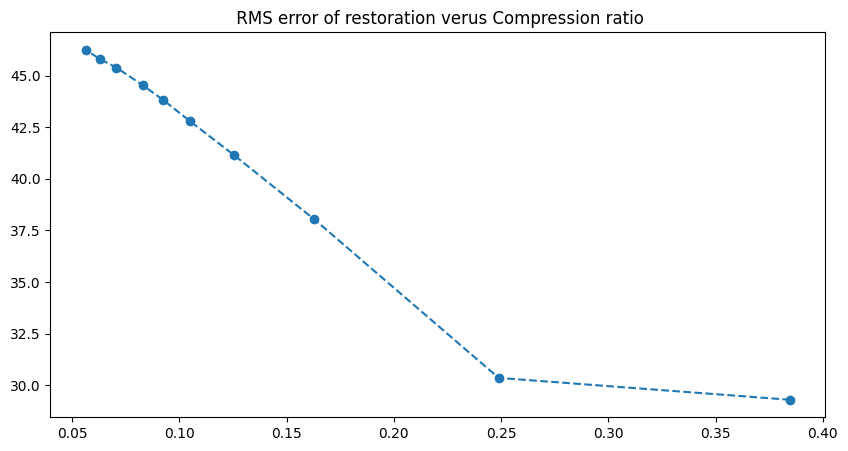

In [12]:
qualities = [1,2,4,6,8,10,12,16,20,25]
ratios = []
RMS = []
M = img.shape[0]
N = img.shape[1]
for q in qualities:
    rms = 0
    jpeg = im2jpeg(img, quality = q)
    ratio = imratio(img, jpeg)
    ratios.append(ratio)
    restored_img = jpeg2im(jpeg)
    for x in range(M):
       for y in range(N):
          rms += (restored_img[x,y] - img[x,y])**2
    rms = math.sqrt(rms/(M*N))
    RMS.append(rms)

plt.figure(figsize=(10,5))
plt.subplot(111)
plt.plot(ratios, RMS, linestyle='--', marker='o')
plt.title(' RMS error of restoration verus Compression ratio')



# **(h) We can see from the graph above the Rate-Distortion Curve. Looking at the graph, what can you say about the relation between the RMS error of restoration and the compression ratio? explain your claim.**

3.	Repeat question 2.3 for block sizes __4X4__ and __16X16__. 

There are 1048576 elements in the original image
There are 461216 elements in the compressed image
Compression rate : 0.44


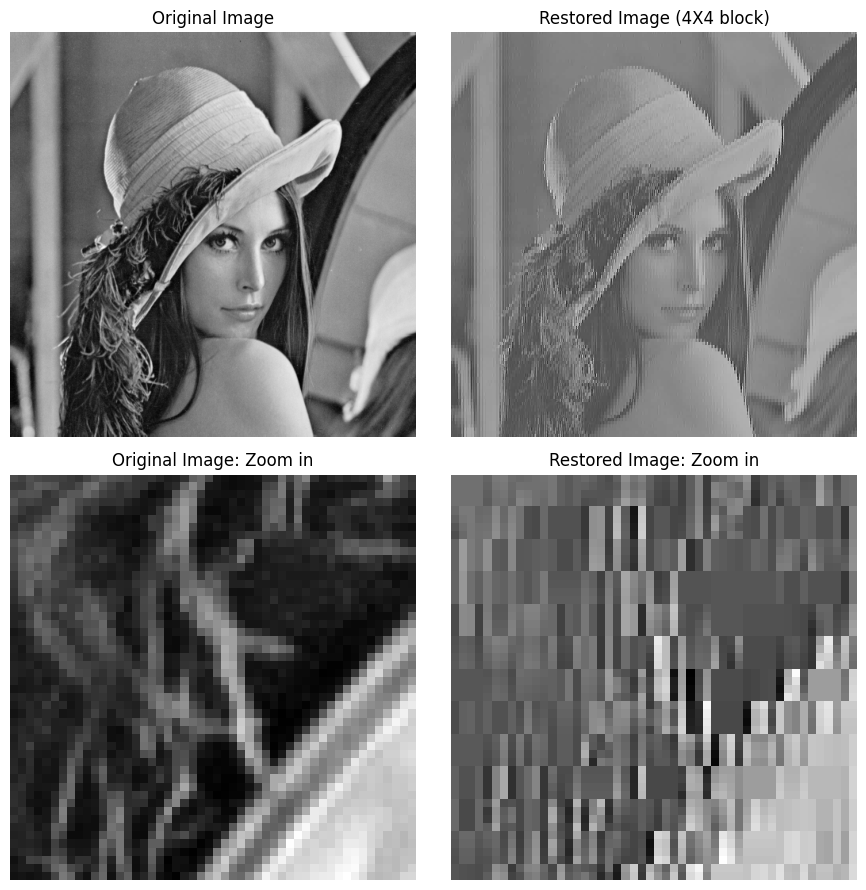

In [13]:
compressed = im2jpeg(img, block_size = 4)
restored = jpeg2im(compressed, block_size = 4)
print(f'There are {str(img.nbytes)} elements in the original image')
print(f'There are {str(compressed.nbytes)} elements in the compressed image')
print (f'Compression rate : {round(float(compressed.nbytes/img.nbytes), 3)}')

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 9))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image'), ax[0].axis('off')
ax[1].imshow(restored, cmap='gray')
ax[1].set_title('Restored Image (4X4 block)'), ax[1].axis('off')
ax[2].imshow(img[200:250,200:250], cmap='gray')
ax[2].set_title("Original Image: Zoom in"), ax[2].axis('off')
ax[3].imshow(restored[200:250,200:250], cmap='gray')
ax[3].set_title("Restored Image: Zoom in"), ax[3].axis('off')
plt.tight_layout()



There are 1048576 elements in the original image
There are 472808 elements in the compressed image
Compression rate : 0.451


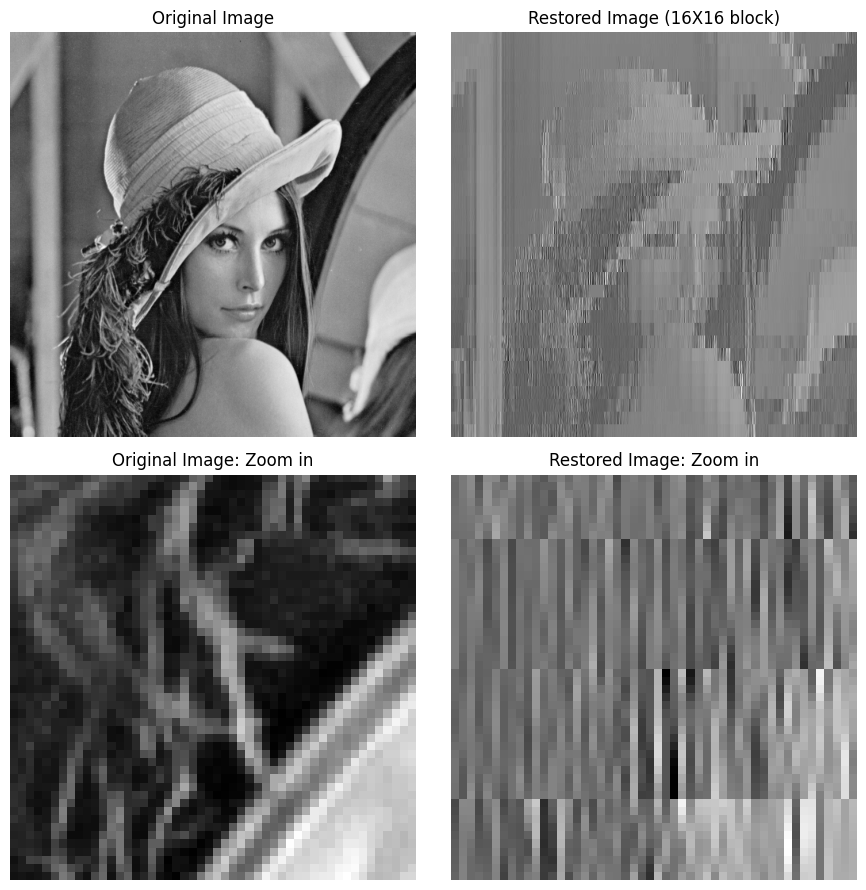

In [14]:
compressed = im2jpeg(img, block_size=16)
restored = jpeg2im(compressed, block_size=16)
print(f'There are {str(img.nbytes)} elements in the original image')
print(f'There are {str(compressed.nbytes)} elements in the compressed image')
print (f'Compression rate : {round(float(compressed.nbytes/img.nbytes), 3)}')

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (9, 9))
ax = axes.ravel()
ax[0].imshow(img, cmap='gray')
ax[0].set_title('Original Image'), ax[0].axis('off')
ax[1].imshow(restored, cmap='gray')
ax[1].set_title('Restored Image (16X16 block)'), ax[1].axis('off')
ax[2].imshow(img[200:250,200:250], cmap='gray')
ax[2].set_title("Original Image: Zoom in"), ax[2].axis('off')
ax[3].imshow(restored[200:250,200:250], cmap='gray')
ax[3].set_title("Restored Image: Zoom in"), ax[3].axis('off')
plt.tight_layout()

# **(i) Look at the restored images for the 4x4 & 16x16 blocks.**
# **- Compare blocking effects for different block sizes.** 
# **- Compare the compression of the algorithm for different block sizes.**
# **- What are the advantages and disadvantages of changing the block size?**

4. Use the following python build in function for JPEG compression:
        result = Image.fromarray((img).astype(np.uint8))
        result.save(Compressed_File_Name,"JPEG",optimize=True,quality= Your_quality)
   * Compress your image by using this function.
   * Load and show the compressed image. 
   * Compare the saved compressed image size in memory vs. the origonal image size.
   * Plot the compressed imag with quality of: 4, 10, 60.
   
   
__Note__: The 'quality' parameter is different here from the 'quality' parameter that we used in this lab implementation.


(Text(0.5, 1.0, 'Python Compression (quality = 60)'),
 (-0.5, 511.5, 511.5, -0.5))

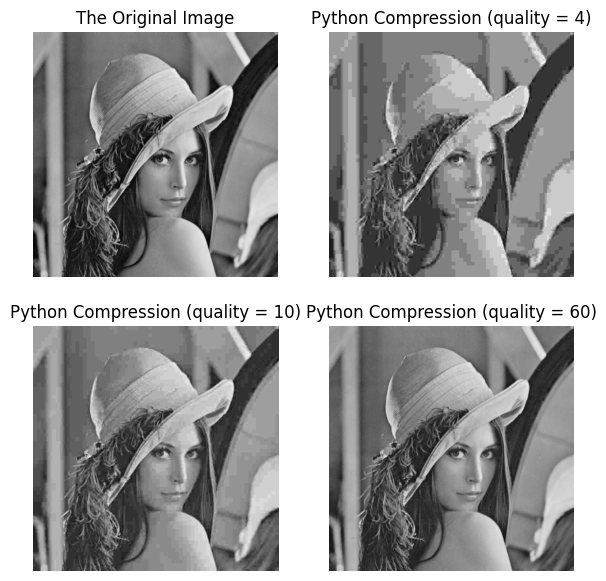

In [15]:
result = Image.fromarray((img).astype(np.uint8))
result.save('/content/drive/My Drive/original',"JPEG")  # you can change here the "JPEG" to "PNG" and see the difference in the quality and file size!
result.save('/content/drive/My Drive/compressed_4',"JPEG",optimize=True,quality= 4)
compressed_4 = Image.open('/content/drive/My Drive/compressed_4')
result.save('/content/drive/My Drive/compressed_10',"JPEG",optimize=True,quality= 10)
compressed_10 = Image.open('/content/drive/My Drive/compressed_10')
result.save('/content/drive/My Drive/compressed_60',"JPEG",optimize=True,quality= 60)
compressed_60 = Image.open('/content/drive/My Drive/compressed_60')


fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (7, 7))
ax = axes.ravel()

ax[0].imshow(img, cmap='gray')
ax[0].set_title('The Original Image'), ax[0].axis('off')
ax[1].imshow(compressed_4, cmap='gray')
ax[1].set_title('Python Compression (quality = 4)'), ax[1].axis('off')
ax[2].imshow(compressed_10, cmap='gray')
ax[2].set_title("Python Compression (quality = 10)"), ax[2].axis('off')
ax[3].imshow(compressed_60, cmap='gray')
ax[3].set_title("Python Compression (quality = 60)"), ax[3].axis('off')




# **(j) After you run the following code, 3 restored images will be saved on your Google Drive.**
# **For each quality parameter - Compare the images in terms of compression ratio, data lost, image quality and the size of the images**
Hint: you can get the size of the images by downloading them from google drive.

Hint2: from the comparisons you've done, see how is the quality factor defined (check whether it is the quality of the compression or the restoration).